## Exploratory analysis 

This notebook explores the request to access to information made to the brazilian government. The data can be found in 
http://www.consultaesic.cgu.gov.br/busca/_layouts/15/DownloadPedidos/DownloadDados.aspx

In [107]:
#importing the necessary libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
import chardet
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = [15, 10]
from bertopic import BERTopic
from umap import UMAP

In [108]:
#avoid any stochastic behaviour in bertopic
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

In [12]:
# Find which encoding to use
with open("../data/20220219_Pedidos_csv_2022.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
print(result)

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


In [13]:
#reading files
recursos_2021 = pd.read_csv("../data/20220219_Recursos_csv_2022.csv",sep=";",
                        header = None,
                        names=['IdRecurso',
                               'IdRecursoPrecedente',
                               'DescRecurso',
                               'IdPedido',
                               'IdSolicitante',
                              'ProtocoloPedido',
                              'OrgaoDestinatario',
                              'Instancia',
                              'Situacao',
                              'DataRegistro',
                              'PrazoAtendimento',
                              'OrigemSolicitacao',
                              'TipoRecurso',
                              'DataResposta',
                              'RespostaRecurso',
                              'TipoResposta'],
                        encoding='UTF-16')

pedidos_2021 = pd.read_csv("../data/20220219_Pedidos_csv_2022.csv",sep=";",
                        header = None,
                        names=['IdPedido',
                              'ProtocoloPedido',
                              'Esfera',
                              'OrgaoDestinatario',
                              'Situacao',
                              'DataRegistro',
                              'ResumoSolicitacao',
                              'DetalhamentoSolicitacao',
                              'PrazoAtendimento',
                              'FoiProrrogado',
                              'FoiReencaminhado',
                              'FormaResposta',
                              'OrigemSolicitacao',
                              'IdSolicitante',
                              'AssuntoPedido',
                              'SubAssuntoPedido',
                              'Tag',
                              'DataResposta',
                              'Resposta',
                              'Decisao',
                              'EspecificacaoDecisao'],
                        encoding='UTF-16')

solicitantes_2021 = pd.read_csv("../data/20220219_Solicitantes_csv_2022.csv",sep=";",
                        header = None,
                        names=['IdSolicitante',
                              'TipoDemandante',
                              'DataNascimento',
                              'Genero',
                              'Escolaridade',
                              'Profissao',
                              'TipoPessoaJuridica',
                              'Pais',
                              'UF',
                              'Municipio'],
                        encoding='UTF-16')

In [14]:
recursos_2021.head()

,IdRecurso,IdRecursoPrecedente,DescRecurso,IdPedido,IdSolicitante,ProtocoloPedido,OrgaoDestinatario,Instancia,Situacao,DataRegistro,PrazoAtendimento,OrigemSolicitacao,TipoRecurso,DataResposta,RespostaRecurso,TipoResposta
0,152195,NaN,"Prezados(as), Agradeço o retorno, porém a resposta quanto à segunda pergunta não parece corresponder à realidade sobretudo no caso de Roraima e com processos minerários com áreas sobrepostas à Terras Indígenas. Dada a resposta ""Resposta: Os processos irão à disponibilidade, não tem outra forma, isto é determinante."" Pois, ao contrário do que ocorre nas Terras Indígenas do Pará, em que os processos abertos nas Terras Indígenas do respectivo estado, são constantemente indeferidos e inativados, nas Terras Indígenas de Roraima, prevalecem ativos processos minerários anteriores à 1990, ou seja, anterior à homologação da TI Yanomami, por exemplo, e também posteriores à homologação em 1992. Então aqui seguem as perguntas sobre esses casos específicos: A) Os processos minerários com sobreposição à Terras Indígenas, mesmo que protocolados anteriormente a homologação da mesma, já não deveriam constar como inativos? Visto que, em sua maioria, os processos minerários ativos e sobrepostos às Terras Indígenas de RR possuem em comum os últimos eventos: -Código 111: Req Pesquisa/Consulta FUNAI Encaminhada, - Código 619: Req Pesq/Processo Situado em Área Indígena (a maioria com os eventos registrados antes de 2005), - Código 157: Req Pesq/Desistência Req Pesq Homologada Pub (a maioria com os eventos registrados antes de 2018), - Código 136: Req Pesq/Documento Diverso Protocolizado. Reforço a pergunta, dado que a maioria desses processos ATIVOS que sobrepõem Terras Indígenas em RR, concentram como últimos eventos por exemplo a situação locacional (que não regulamenta a mineração em Terras Indígenas) e a desistência do requerimento de pesquisa antes mesmo de obter o título, por que esses processos permanecem ativos mesmo com o último evento ocorrendo por exemplo em junho de 2005. B) Caso a regulamentação da mineração em Terras Indígenas seja aprovada, esses processos que sobrepõem as Terras Indígenas em Roraima e permanecem ativos ainda hoje, terão prioridade, na área do respectivo processo, para exercer a atividade de pesquisa requisitada originalmente (sendo a maioria protocolado em 1984 e que continuam ativo)? Ou seja, mesmo com a desistência do requerimento já homologada, mesmo com a situação locacional hoje definida como não regulamentar, a situação do processo constar como ATIVO, pode privilegiar, pelo princípio da prioridade, os responsáveis legais por determinados processos a exercerem, de forma prioritária, a atividade mediante regulamentação da atividade, ou novos processos deverão ser protocolados?",3880026,0,48003000013202207,ANM - Agência Nacional de Mineração,Primeira Instância,Respondido,03/01/2022,10/01/2022,Internet,Informação incompleta,03/01/2022,"A) Os processos minerários com sobreposição à Terras Indígenas, mesmo que protocolados anteriormente a homologação da mesma, já não deveriam constar como inativos? Visto que, em sua maioria, os processos minerários ativos e sobrepostos às Terras Indígenas de RR possuem em comum os últimos eventos: -Código 111: Req Pesquisa/Consulta FUNAI Encaminhada, - Código 619: Req Pesq/Processo Situado em Área Indígena (a maioria com os eventos registrados antes de 2005), - Código 157: Req Pesq/Desistência Req Pesq Homologada Pub (a maioria com os eventos registrados antes de 2018), - Código 136: Req Pesq/Documento Diverso Protocolizado. Reforço a pergunta, dado que a maioria desses processos ATIVOS que sobrepõem Terras Indígenas em RR, concentram como últimos eventos por exemplo a situação locacional (que não regulamenta a mineração em Terras Indígenas) e a desistência do requerimento de pesquisa antes mesmo de obter o título, por que esses processos permanecem ativos mesmo com o último evento ocorrendo por exemplo em junho de 2005. Resposta: Processo em Terra In

In [15]:
pedidos_2021.head()

,IdPedido,ProtocoloPedido,Esfera,OrgaoDestinatario,Situacao,DataRegistro,ResumoSolicitacao,DetalhamentoSolicitacao,PrazoAtendimento,FoiProrrogado,FoiReencaminhado,FormaResposta,OrigemSolicitacao,IdSolicitante,AssuntoPedido,SubAssuntoPedido,Tag,DataResposta,Resposta,Decisao,EspecificacaoDecisao
0,3878674,60141000001202295,Federal,COMAER – Comando da Aeronáutica,Concluída,01/01/2022,Porque a FAB é chamada de Comando da Aeronaútica do DOU e não Força Aerea Brasileira?,Porque a FAB é chamada de Comando da Aeronaútica do DOU e não Força Aerea Brasileira?,03/02/2022,Sim,Não,Pelo sistema (com avisos por email),Internet,1145978,Acesso à informação,NaN,,02/02/2022,"MINISTÉRIO DA DEFESA COMANDO DA AERONÁUTICA Centro de Comunicação Social da Aeronáutica Senhor Lázaro, Sobre a solicitação em comento, inicialmente, cumpre-nos informar que o canal utilizado não se presta para esclarecimentos de dúvidas, interpretação de normas/legislação, nem de providências para os órgãos públicos. Nada obstante, sugerimos que leia as normas de criação do, então, Ministério da Aeronáutica, Decreto-Lei nº 2.961, de 20 de janeiro de 1941, sua transformação em Comando da Aeronáutica, Medida Provisória nº 2.216-37, de 31 de agosto de 2001, e da Força Aérea Brasileira, Decreto-Lei nº 3.302, de 22 de maio de 1941. As legislações referenciadas podem ser obtidas nos seguintes links: http://www.planalto.gov.br/ccivil_03/mpv/2216-37.htm http://www.planalto.gov.br/CCiVil_03/Decreto-Lei/1937-1946/Del2961.htm https://www2.camara.leg.br/legin/fed/declei/1940-1949/decreto-lei-3302-22-maio-1941-413224-publicacaooriginal-1-pe.html Serviço de Informações ao Cidadão Centro de Comunicação Social da Aeronáutica Esplanada dos Ministérios – Bloco M - 7º andar – Brasília – Distrito Federal CEP 70.045-900.",Não se trata de solicitação de informação,NaN
1,3878729,23546000005202294,Federal,UFMS – Fundação Universidade Federal de Mato Grosso do Sul,Concluída,01/01/2022,Solicita Informações Telefones Celulares Corporativos (Funcionais),"Em atenção aos enunciados dos art. 6º, VI, e art. 10 da Lei de Acesso à Informação Art. 6º Cabe aos órgãos e entidades do poder público, observadas as normas e procedimentos específicos aplicáveis, assegurar a: VI - informação pertinente à administração do patrimônio público, utilização de recursos públicos, licitação, contratos administrativos, e Art. 10. Qualquer interessado poderá apresentar pedido de acesso a informações aos órgãos e entidades referidos no art. 1º desta Lei, por qualquer meio legítimo, devendo o pedido conter a identificação do requerente e a especificação da informação requerida. Solicito uma lista, com o nome completo e lotação, de todos os servidores técnicos e docentes da UFMS que estão em posse de celulares corporativos (funcionais). Ressalto que não me interessa o número dos respectivos aparelhos, apenas quem são os agentes públicos da UFMS e em quais lugares atuam na UFMS. Ressalto, ainda, que a informação solicitada não está abrangida por qualquer restrição constitucional existente como o sigilo bancário ou fiscal. Att.,",24/01/2022,Não,Não,Pelo sistema (com avisos por email),Internet,1295308,Acesso à informação,Informação sobre servidor(es),Telefone(s) Celular(es) Funcional(is),11/01/2022,"Boa tarde! Agradecemos por nos contatar. Informamos que sua demanda foi analisada pela Ouvidoria e encaminhada à área competente, Gabinte da Pró-Reitoria de Administração e Infraestrutura, que nos enviou a seguinte resposta: __________________________________ Bom dia, Seguem as informações solicitadas sobre as linhas ativas e desbloqueadas no momento: Camila Celeste Brandao Ferreira Itavo - Reitoria Cleuir Viegas da Silva Mascarenhas - Rádio Educativa UFMS 99.9 Jamil Farrhat Valentim - Reitoria Luciano Gonda - Agetic Marcelo Augusto Santos Turine - Reitoria Nilton Conde Torres - Diserv/Proadi Bianca Berigo Ferreira - Seman/Dinfra/Proadi Informamos que há também 16 linhas ativas que compõem o sistema PABX da UFMS. ________________________

In [16]:
solicitantes_2021.head()

,IdSolicitante,TipoDemandante,DataNascimento,Genero,Escolaridade,Profissao,TipoPessoaJuridica,Pais,UF,Municipio
0,2782,Pessoa Física,NaN,Masculino,NaN,NaN,NaN,NaN,PARANÁ,Almirante Tamandaré
1,9063,Pessoa Física,NaN,Masculino,NaN,NaN,NaN,NaN,TOCANTINS,Paraíso do Tocantins
2,9744,Pessoa Física,NaN,Masculino,NaN,NaN,NaN,NaN,MATO GROSSO DO SUL,Campo Grande
3,16507,Pessoa Física,NaN,Masculino,NaN,NaN,NaN,NaN,BAHIA,Serrinha
4,22056,Pessoa Física,NaN,NaN,NaN,NaN,NaN,NaN,GOIÁS,Goiânia


# Analysis of file "Pedidos"

In [17]:
pedidos_path = glob.glob("../data/20220219_Pedidos_csv_*")
files_list = []

for filename in pedidos_path:
    
    pedidos_file = pd.read_csv(filename,
                               sep=";",
                               quotechar="'",
                        header = None,
                        names=['IdPedido',
                              'ProtocoloPedido',
                              'Esfera',
                              'OrgaoDestinatario',
                              'Situacao',
                              'DataRegistro',
                              'ResumoSolicitacao',
                              'DetalhamentoSolicitacao',
                              'PrazoAtendimento',
                              'FoiProrrogado',
                              'FoiReencaminhado',
                              'FormaResposta',
                              'OrigemSolicitacao',
                              'IdSolicitante',
                              'AssuntoPedido',
                              'SubAssuntoPedido',
                              'Tag',
                              'DataResposta',
                              'Resposta',
                              'Decisao',
                              'EspecificacaoDecisao'],
                               keep_default_na=False,
                        encoding='UTF-16 LE')
    
    files_list.append(pedidos_file)

pedidos = pd.concat(files_list, axis=0, ignore_index=True)


In [59]:
pedidos_file.head()

,IdPedido,ProtocoloPedido,Esfera,OrgaoDestinatario,Situacao,DataRegistro,ResumoSolicitacao,DetalhamentoSolicitacao,PrazoAtendimento,FoiProrrogado,FoiReencaminhado,FormaResposta,OrigemSolicitacao,IdSolicitante,AssuntoPedido,SubAssuntoPedido,Tag,DataResposta,Resposta,Decisao,EspecificacaoDecisao
0,1887837,23480010257201512,Federal,UFPel – Fundação Universidade Federal de Pelotas,Concluída,01/07/2015,Aproveitamento,"Prezados, Gostaria de solicitar informações sobre a existência de vagas para aproveitamento na UFPEL. Busco informações sobre vagas referentes ao cargo de Técnico em Assuntos Educacionais. Existe alguma vaga em aberto para este cargo na instituição? No caso da existência da vaga, quais critérios e procedimentos necessários para a solicitação da mesma? Desde já, agradeço a atenção",21/07/2015,Não,Não,Pelo sistema (com avisos por email),Internet,2564814,Conduta Docente,,,29/10/2015,"Boa tarde, Em primeiro lugar, pedimos desculpas pelo atraso no envio da resposta a seu questionamento, justificado pela ocorrência da greve dos servidores públicos federais. Atendendo a sua solicitação, recebemos a seguinte resposta da Pró-Reitoria de Gestão de Pessoas:""Informamos que a vaga de Técnico em Assuntos Educacionais existente já está em processo de redistribuição, restando apenas a anuência da Universidade de origem do servidor selecionado e a publicação da redistribuição junto ao MEC."" Att. Biolange Piegas/Ouvidoria/e-SIC/UFPel",Acesso Concedido,Resposta solicitada inserida no Fala.Br
1,1887842,23480010258201559,Federal,UFRGS – Universidade Federal do Rio Grande do Sul,Concluída,01/07/2015,Aproveitamento,"Prezados, Gostaria de solicitar informações sobre a existência de vagas para aproveitamento na UFRGS. Busco informações sobre vagas referentes ao cargo de Técnico em Assuntos Educacionais. Existe alguma vaga em aberto para este cargo na instituição? No caso da existência da vaga, quais critérios e procedimentos necessários para a solicitação da mesma? Desde já, agradeço a atenção",21/07/2015,Não,Não,Pelo sistema (com avisos por email),Internet,2564814,Outros em Trabalho,,,02/07/2015,"Senhor Jomar Em atendimento à sua solicitação, a A Pró-Reitoria de Gestão de Pessoas da UFRGS respondeu que dispõe de 4 vagas do cargo de Técnico em Assuntos Educacionais, com previsão de nomeação para o mês de julho. Atenciosamente, Profa. Ana Maria e Souza Braga Ouvidora da UFRGS.",Acesso Concedido,Resposta solicitada inserida no Fala.Br
2,1887846,23480010259201501,Federal,"IFPI – Instituto Federal de Educação, Ciência e Tecnologia do Piauí",Concluída,01/07/2015,Aproveitamento,"Prezados, Gostaria de solicitar informações sobre a existência de vagas para aproveitamento na IFPI. Busco informações sobre vagas referentes ao cargo de Técnico em Assuntos Educacionais. Existe alguma vaga em aberto para este cargo na instituição? No caso da existência da vaga, quais critérios e procedimentos necessários para a solicitação da mesma? Desde já, agradeço a atenção",21/07/2015,Não,Não,Pelo sistema (com avisos por email),Internet,2564814,Conduta Docente,,,29/11/2016,Não há vagas disponíveis para o referido cargo.,Acesso Concedido,Resposta solicitada inserida no Fala.Br
3,1887851,23480010260201528,Federal,UFCG – Universidade Federal de Campina Grande,Concluída,01/07/2015,Aproveitamento,"Prezados, Gostaria de solicitar informações sobre a existência de vagas para aproveitamento na UFCG. Busco informações sobre vagas referentes ao cargo de Técnico em Assuntos Educacionais. Existe alguma vaga em aberto para este cargo na instituição? No caso da existência da vaga, quais critérios e procedimentos necessários para a solicitação da mesma? Desde já, agradeço a atenção",21/07/2015,Não,Não,Pelo sistema (com avisos por email),Internet,2564814,Educação Superior,,,01/07/2015,"Não dispomos de vaga em aberto, para o cargo de Técnico de Assuntos Educacionais, classe E. Para solicitar basta entrar com requerimento escrito endereçando à SEPLAN (Secretaria de Planejamento da UF

In [60]:
pedidos_file.shape

(71193, 21)

In [25]:
#formatting date columns
pedidos['DataRegistro_formatted'] =  pd.to_datetime(pedidos.DataRegistro,errors='coerce', format="%d/%m/%Y")
pedidos['PrazoAtendimento_formatted'] =  pd.to_datetime(pedidos.PrazoAtendimento, errors='coerce',format="%d/%m/%Y")
pedidos['DataResposta_formatted'] =  pd.to_datetime(pedidos.DataResposta,errors='coerce', format="%d/%m/%Y")


In [26]:
#we found a few misformatted rows
pedidos[(pedidos.DataRegistro_formatted.isna()) |\
        (pedidos.PrazoAtendimento_formatted.isna()) |\
        (pedidos.DataResposta_formatted.isna())].shape

(92, 24)

# Requests over time

In [27]:
pedidos_over_time = pedidos[['IdPedido',
                             'DataRegistro_formatted']].groupby([pedidos.DataRegistro_formatted.dt.year,
                                                               pedidos.DataRegistro_formatted.dt.month]).count()

In [28]:
pedidos_over_time

IdPedido  \
DataRegistro_formatted DataRegistro_formatted             
2015                   1                           5782   
                       2                           4631   
                       3                           6901   
                       4                           6575   
                       5                           5493   
...                                                 ...   
2021                   10                          5764   
                       11                          5603   
                       12                          3741   
2022                   1                           5362   
                       2                           1564   

                                               DataRegistro_formatted  
DataRegistro_formatted DataRegistro_formatted                          
2015                   1                                         5782  
                       2                                         4631  
                       3                                         6901  
                       4                                         6575  
                       5                                         5493  
...                                                               ...  
2021                   10                                        5764  
                       11                                        5603  
                       12                                        3741  
2022                   1                                         5362  
                       2                                         1564  

[86 rows x 2 columns]

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

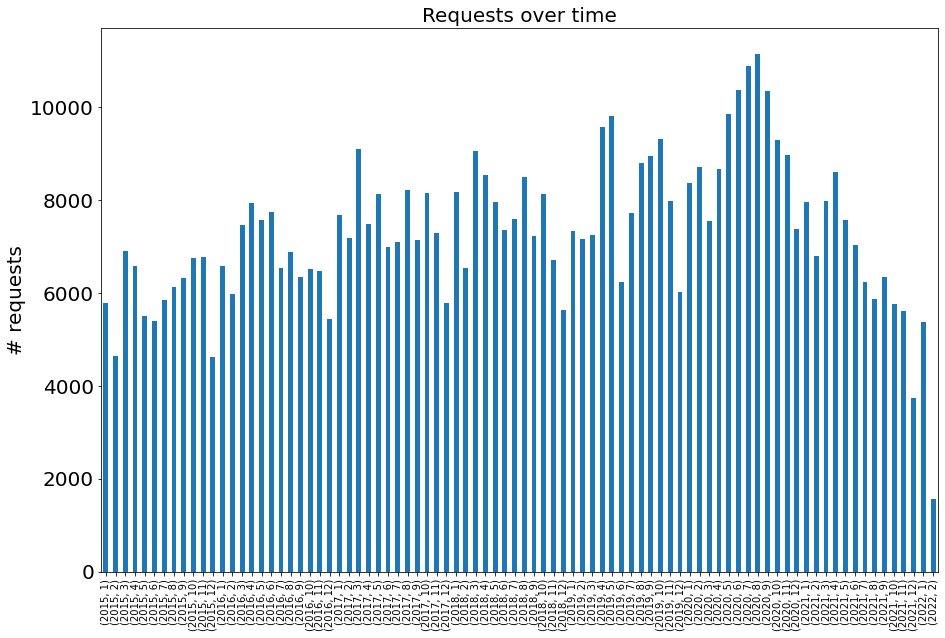

In [37]:
pedidos_over_time['IdPedido'].plot.bar()
plt.title('Requests over time',size=20)
plt.xlabel('')
plt.ylabel('# requests',size=20)
plt.yticks(size=20)

In [38]:
pedidos_over_time = pedidos[['IdPedido',
                             'DataRegistro_formatted']].groupby([pedidos.DataRegistro_formatted.dt.year,
                                                               pedidos.DataRegistro_formatted.dt.month]).count()

As we are particularly interested in how the category of "access to information is evolving" we can add this layer as well in the plot

In [39]:
len(set(pedidos.AssuntoPedido))

180

In [40]:
pedidos[['IdPedido','AssuntoPedido']].groupby('AssuntoPedido').count().sort_values(by='IdPedido',ascending=False)

,IdPedido
AssuntoPedido,
Acesso à informação,96147
Serviços Públicos,67882
Outros em Economia e Finanças,62842
Educação Superior,40787
Outros em Saúde,28096
...,...
Esporte Comunitário,9
Difusão,8
Rede Brasileira de Metrologia e Qualidade Inmetro (RBMLQ-I),4


There are 180 categories, and access to information is the biggest one. To declutter our visualization, we will create two categories "access to information" and "others"

In [41]:
pedidos.loc[pedidos.AssuntoPedido == 'Acesso à informação','Access_to_information'] = True
pedidos.loc[pedidos.AssuntoPedido != 'Acesso à informação','Access_to_information'] = False


In [42]:
pedidos_over_time_by_assunto = pedidos[['IdPedido',
                             'DataRegistro_formatted',
                                       'Access_to_information']].groupby(['DataRegistro_formatted',
                                                                 'Access_to_information']).count()

In [43]:
pedidos_over_time_by_assunto.reset_index(level=1,inplace=True)

In [44]:
pedidos_over_time_by_assunto = pedidos_over_time_by_assunto.pivot(columns='Access_to_information',values='IdPedido')

In [45]:
pedidos_over_time_by_assunto.fillna(0,inplace=True)

In [46]:
pedidos_over_time_by_assunto = pedidos_over_time_by_assunto.groupby([pedidos_over_time_by_assunto.index.year,
                                                pedidos_over_time_by_assunto.index.month]).sum()

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

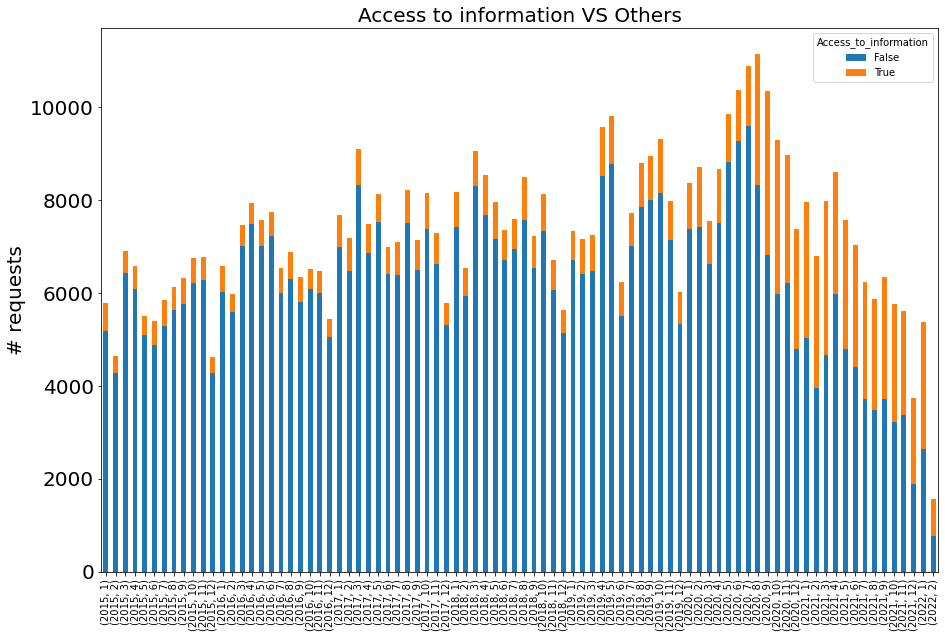

In [57]:
pedidos_over_time_by_assunto.plot.bar(stacked=True)
plt.title('Access to information VS Others',size=20)
plt.ylabel('# requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

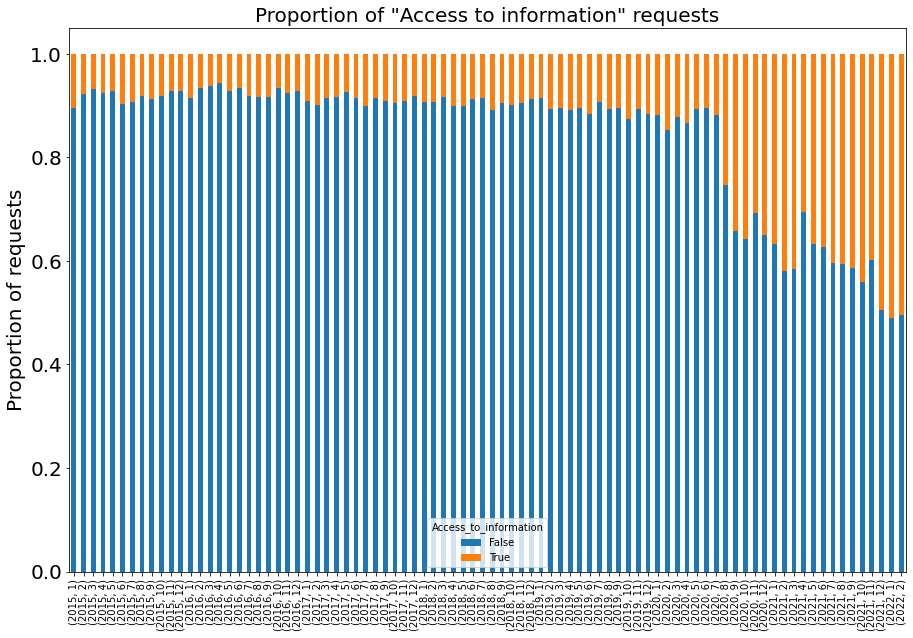

In [62]:
pedidos_over_time_by_assunto.div(pedidos_over_time_by_assunto.sum(axis=1).values,axis=0).plot.bar(stacked=True)
plt.title('Proportion of "Access to information" requests',size=20)
plt.ylabel('Proportion of requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

Access to information requests is not only the biggest category but has been growing over time, occupying roung 40% of the total requests made recently 

# Understanding "Access to information" category

In [63]:
pedidos_access_to_information = pedidos[pedidos.AssuntoPedido == 'Acesso à informação']

In [64]:
pedidos_access_to_information[['IdPedido','Esfera']].groupby('Esfera').count()

,IdPedido
Esfera,
Federal,96147


In [65]:
pedidos_access_to_information[['IdPedido',
                               'OrgaoDestinatario']].groupby('OrgaoDestinatario').count().sort_values(by='IdPedido',\
                                                                                                      ascending=False)

,IdPedido
OrgaoDestinatario,
FUNAI – Fundação Nacional do Índio,5665
"ANP – Agência Nacional do Petróleo, Gás Natural e Biocombustíveis",4951
ANEEL – Agência Nacional de Energia Elétrica,4386
PETROBRAS – Petróleo Brasileiro S.A.,3699
ANVISA – Agência Nacional de Vigilância Sanitária,3366
...,...
DPU – Defensoria Pública da União,1
EBSERH - CHC-UFC (HUWC) - Hospital Universitário Walter Cântídio,1
EBSERH - HU-UFGD – Hospital Universitário de Grande Dourados,1


All requests happened at the federal level and generally to FUNAI or energy related institutions

In [66]:
pedidos_access_to_information[['IdPedido','Decisao']].groupby('Decisao').count().sort_values(by='IdPedido',
                                                                                             ascending=False)

,IdPedido
Decisao,
Acesso Concedido,71785
Acesso Negado,6849
Acesso Parcialmente Concedido,5192
Informação Inexistente,4079
Não se trata de solicitação de informação,3844
Pergunta Duplicada/Repetida,2273
Órgão não tem competência para responder sobre o assunto,2120
06/10/2020,1
"Prezada Sra. Em resposta ao registro de acesso à informação nº 23546.056511/2020-76, encaminhamos em anexo as informações disponibilizadas pela Coordenação de Extensão e Cultura (CEC) do Centro de Ciências Jurídicas (CCJ). Atenciosamente, Serviço de Informação ao Cidadão Universidade Federal de Pernambuco Eventuais recursos devem ser dirigidos à autoridade hierarquicamente superior à que adotou a decisão, no prazo de 10 (dez) dias, contados da ciência da decisão (Art. 21 Decreto 7.724/2012). Nesse caso, deve-se clicar no botão correspondente no sistema e apresentar as razões do recurso. Informamos que novos questionamentos devem ser objeto de novo pedido de informação na plataforma Fala.BR, link: https://www.gov.br/acessoainformacao/pt-br/falabr",1


In [67]:
pedidos_access_to_information_by_decisao = pedidos_access_to_information[['IdPedido',
                              'DataRegistro_formatted',
                              'Decisao']].groupby(['DataRegistro_formatted','Decisao']).count()

In [68]:
pedidos_access_to_information_by_decisao.reset_index(level=1,inplace=True)

In [69]:
pedidos_access_to_information_by_decisao = pedidos_access_to_information_by_decisao.pivot(columns='Decisao',
                                               values='IdPedido')[['Acesso Concedido',
                                                'Acesso Negado',
                                                'Acesso Parcialmente Concedido',
                                                'Informação Inexistente',
                                                'Não se trata de solicitação de informação',
                                                'Pergunta Duplicada/Repetida',
                                                'Órgão não tem competência para responder sobre o assunto']]

In [70]:
pedidos_access_to_information_by_decisao.fillna(0,inplace=True)

In [71]:
pedidos_access_to_information_by_decisao = pedidos_access_to_information_by_decisao.groupby([pedidos_access_to_information_by_decisao.index.year,
                                                 pedidos_access_to_information_by_decisao.index.month]).sum()

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

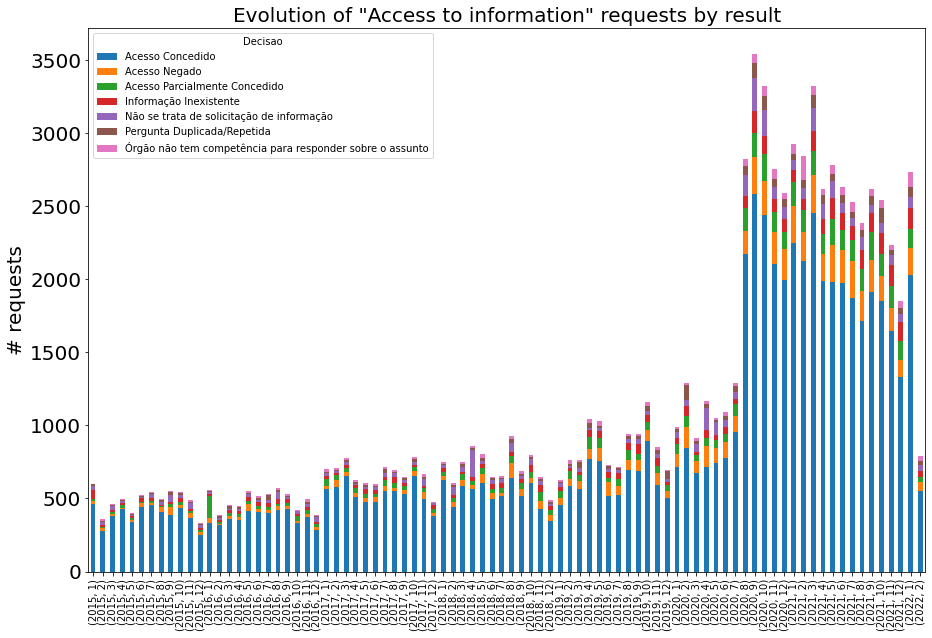

In [79]:
pedidos_access_to_information_by_decisao.plot.bar(stacked=True)
plt.title('Evolution of "Access to information" requests by result',size=20)
plt.xlabel('')
plt.ylabel('# requests',size=20)
plt.yticks(size=20)

In [73]:
pedidos_access_by_decisao_support =  pedidos_access_to_information_by_decisao.div(pedidos_access_to_information_by_decisao.sum(axis=1).values,axis=0)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

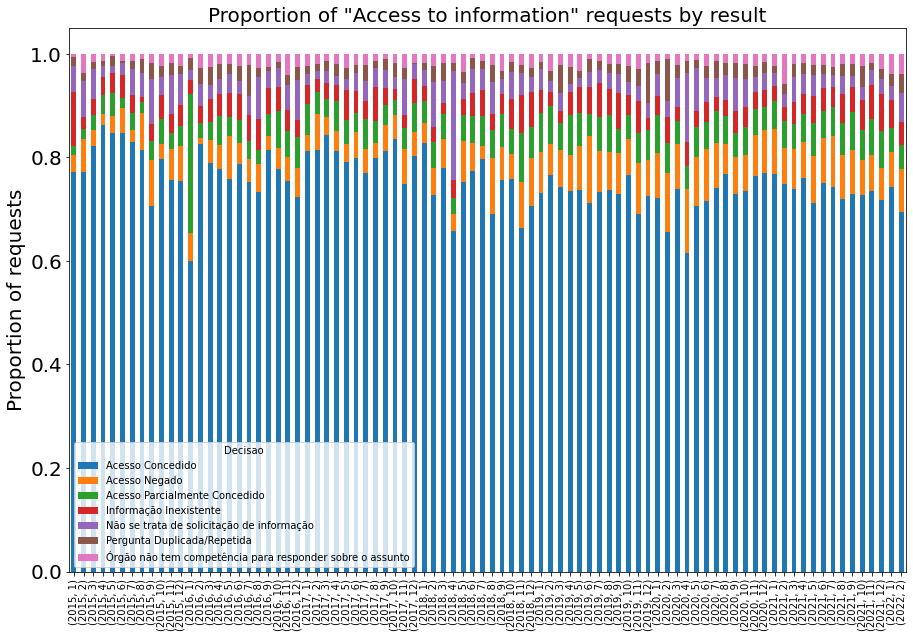

In [78]:
pedidos_access_by_decisao_support.plot.bar(stacked=True)
plt.title('Proportion of "Access to information" requests by result',size=20)
plt.ylabel('Proportion of requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

Text(0.5, 0, '')

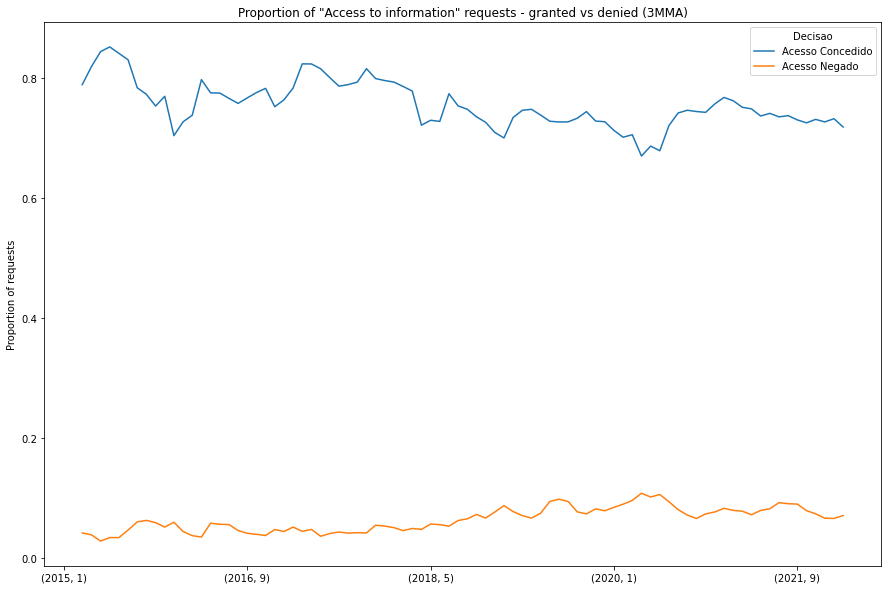

In [75]:
pedidos_access_by_decisao_support.rolling(3).mean()[['Acesso Concedido','Acesso Negado']].plot()
plt.title('Proportion of "Access to information" requests - granted vs denied (3MMA)')
plt.ylabel('Proportion of requests')
plt.xlabel('')

(array([0.65 , 0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 ,
        0.875]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

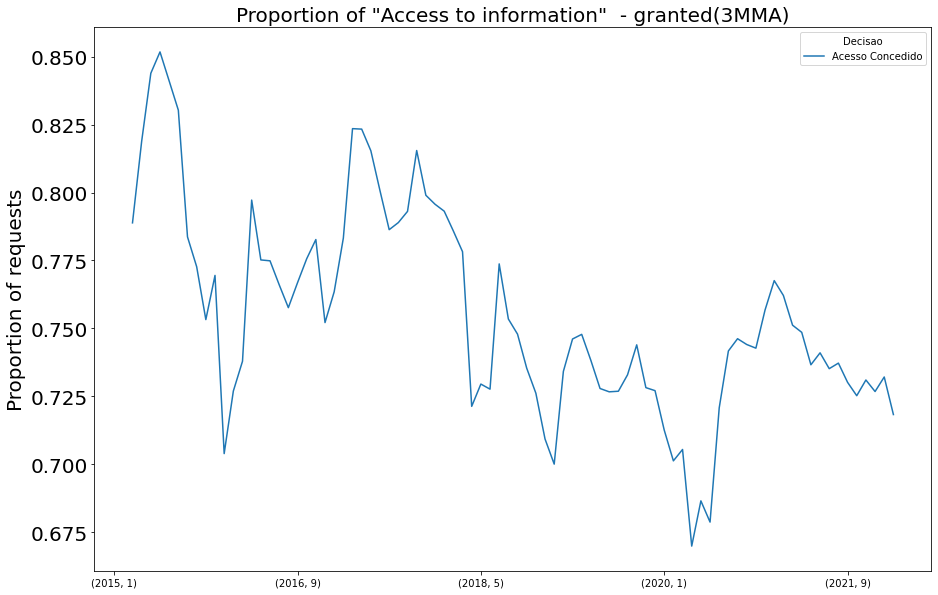

In [81]:
pedidos_access_by_decisao_support.rolling(3).mean()[['Acesso Concedido']].plot()
plt.title('Proportion of "Access to information"  - granted(3MMA)',size=20)
plt.ylabel('Proportion of requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

(array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

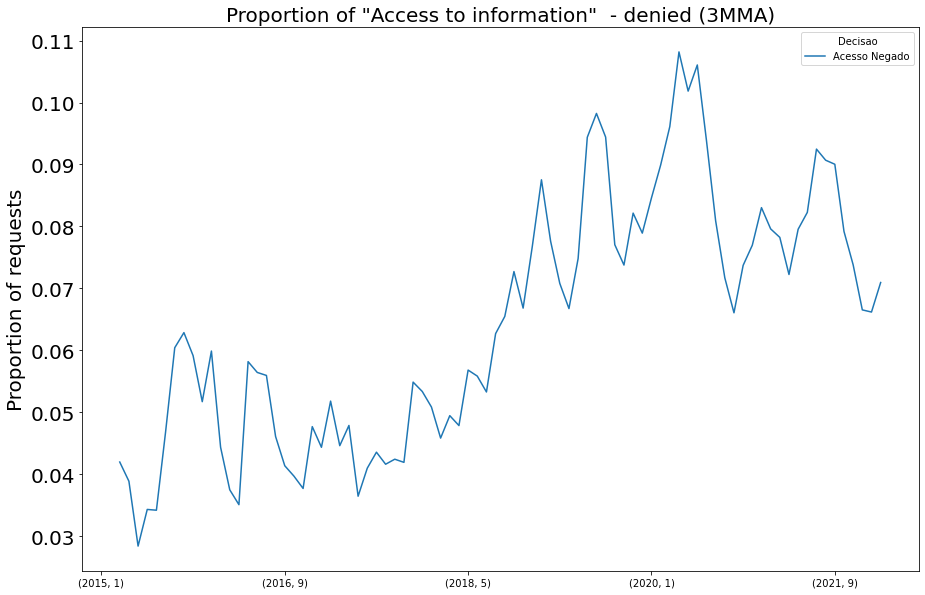

In [82]:
pedidos_access_by_decisao_support.rolling(3).mean()[['Acesso Negado']].plot()
plt.title('Proportion of "Access to information"  - denied (3MMA)',size=20)
plt.ylabel('Proportion of requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

While most of the successfull, we see a increasing trend of denied access over time.

In [83]:
pedidos_access_to_information_denied = pedidos_access_to_information[pedidos_access_to_information.Decisao == 'Acesso Negado']

In [84]:
pedidos_access_to_information_denied = pedidos_access_to_information_denied[['IdPedido',
                                             'DataRegistro_formatted',
                                             'EspecificacaoDecisao']].groupby(['DataRegistro_formatted',
                                                                              'EspecificacaoDecisao']).count()

In [85]:
pedidos_access_to_information_denied.reset_index(level=1,inplace=True)

In [86]:
pedidos_access_to_information_denied = pedidos_access_to_information_denied.pivot(columns='EspecificacaoDecisao',
                                                                                  values='IdPedido')

In [87]:
pedidos_access_to_information_denied.fillna(0,inplace=True)

In [88]:
pedidos_access_to_information_denied = pedidos_access_to_information_denied.groupby([pedidos_access_to_information_denied.index.year,
                                             pedidos_access_to_information_denied.index.month]).sum()

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

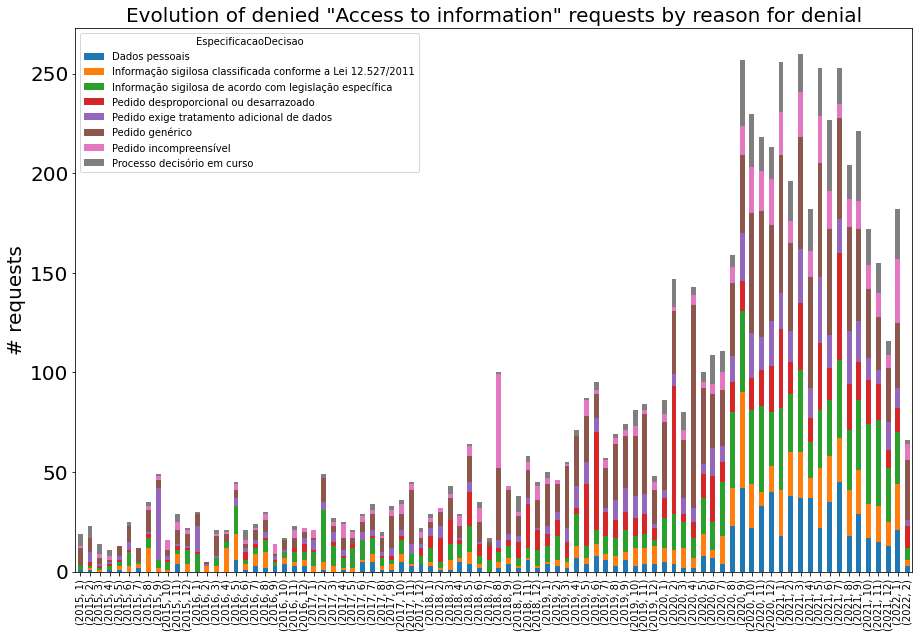

In [91]:
pedidos_access_to_information_denied.plot.bar(stacked=True)
plt.title('Evolution of denied "Access to information" requests by reason for denial',size=20)
plt.ylabel('# requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

In [92]:
pedidos_access_to_information_denied

EspecificacaoDecisao                           Dados pessoais  \
DataRegistro_formatted DataRegistro_formatted                   
2015                   1                                  1.0   
                       2                                  1.0   
                       3                                  0.0   
                       4                                  1.0   
                       5                                  1.0   
...                                                       ...   
2021                   10                                17.0   
                       11                                15.0   
                       12                                13.0   
2022                   1                                 21.0   
                       2                                  3.0   

EspecificacaoDecisao                           Informação sigilosa classificada conforme a Lei 12.527/2011  \
DataRegistro_formatted DataRegistro_formatted                                                                
2015                   1                                                                               0.0   
                       2                                                                               1.0   
                       3                                                                               1.0   
                       4                                                                               0.0   
                       5                                                                               2.0   
...                                                                                                    ...   
2021                   10                                                                             17.0   
                       11                                                                             18.0   
                       12                                                                             12.0   
2022                   1                                                                              23.0   
                       2                                                                               3.0   

EspecificacaoDecisao                           Informação sigilosa de acordo com legislação específica  \
DataRegistro_formatted DataRegistro_formatted                                                            
2015                   1                                                                           2.0   
                       2                                                                           1.0   
                       3                                                                           1.0   
                       4                                                                           2.0   
                       5                                                                           2.0   
...                                                                                                ...   
2021                   10                                                                         40.0   
                       11                                                                         43.0   
                       12                                                                         27.0   
2022                   1                                                                          26.0   
                       2                                                                           6.0   

EspecificacaoDecisao                           Pedido desproporcional ou desarrazoado  \
DataRegistro_formatted DataRegistro_formatted                                           
2015                   1                                                          0.0   
                       2                                                     

In [93]:
pedidos_access_to_information_denied = pedidos_access_to_information_denied.div(pedidos_access_to_information_denied.sum(axis=1).values,axis=0).\
rolling(6).mean()

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

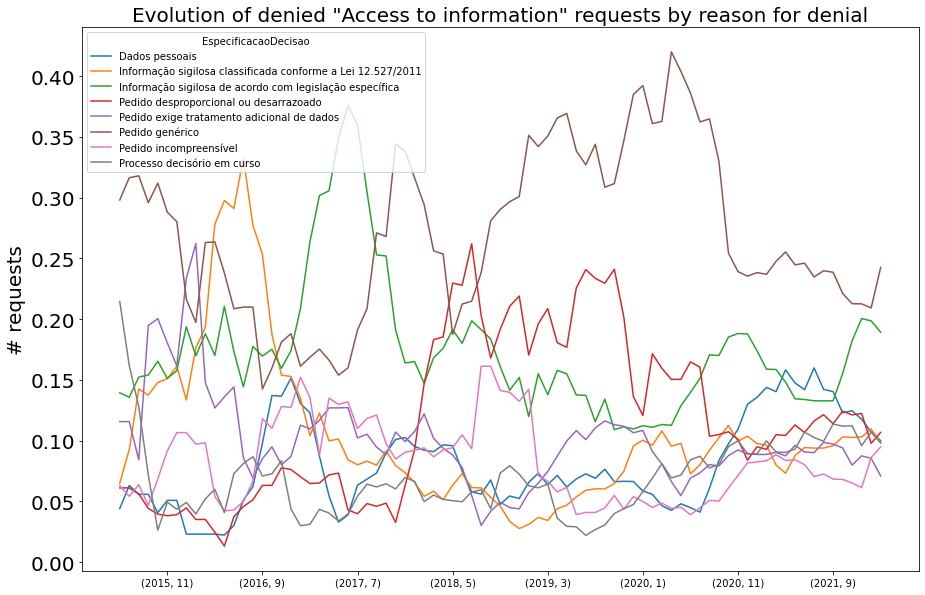

In [94]:
pedidos_access_to_information_denied.plot()
plt.title('Evolution of denied "Access to information" requests by reason for denial',size=20)
plt.ylabel('# requests',size=20)
plt.xlabel('')
plt.yticks(size=20)

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

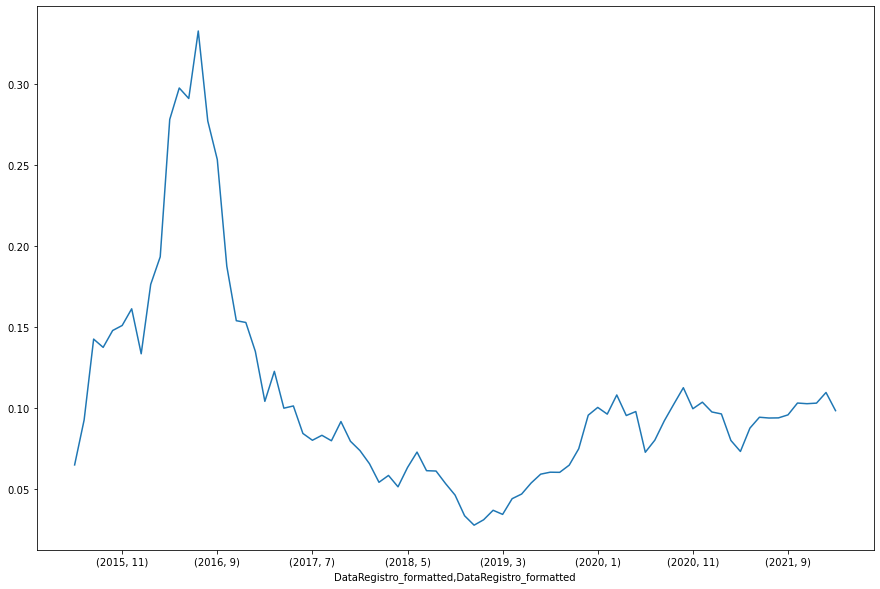

In [95]:
pedidos_access_to_information_denied['Informação sigilosa classificada conforme a Lei 12.527/2011'].plot()

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

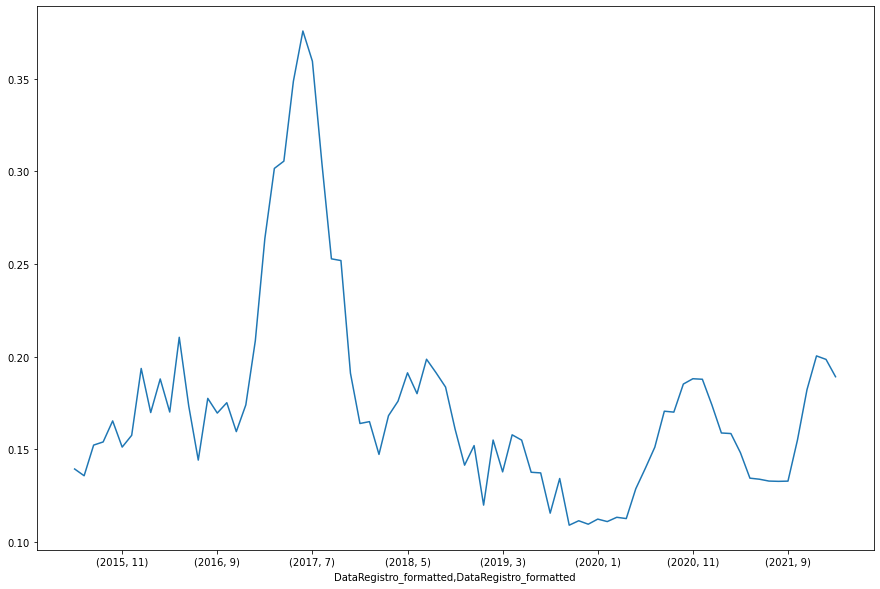

In [96]:
pedidos_access_to_information_denied['Informação sigilosa de acordo com legislação específica'].plot()

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

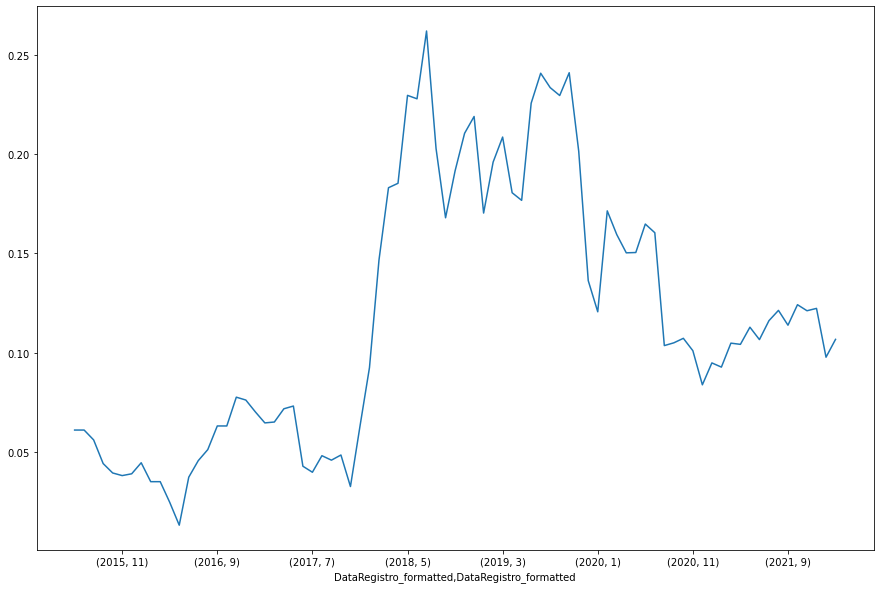

In [97]:
pedidos_access_to_information_denied['Pedido desproporcional ou desarrazoado'].plot()

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

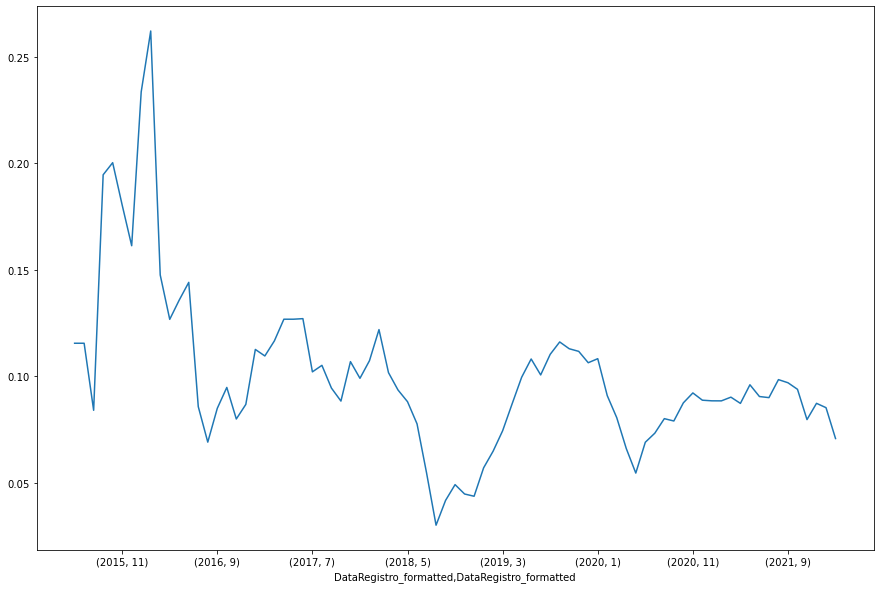

In [98]:
pedidos_access_to_information_denied['Pedido exige tratamento adicional de dados'].plot()

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

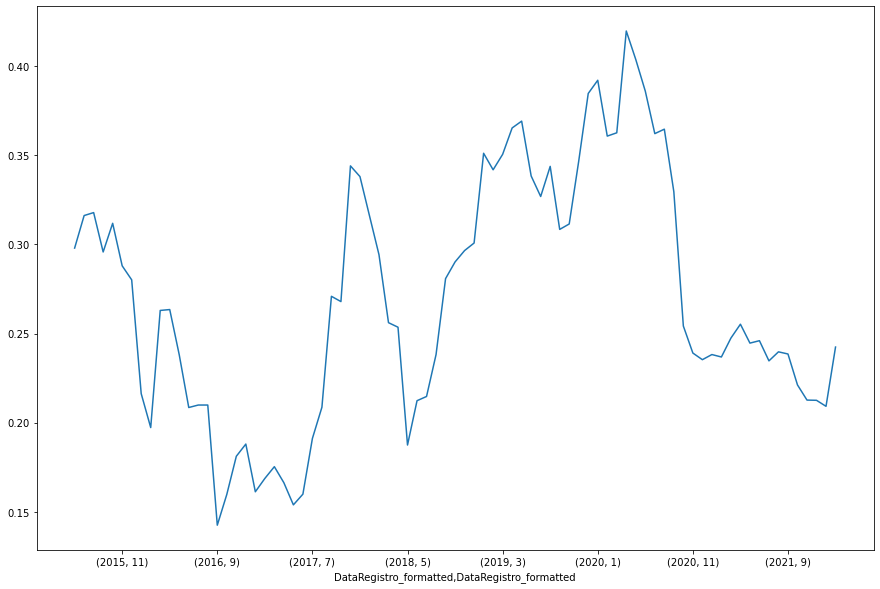

In [99]:
pedidos_access_to_information_denied['Pedido genérico'].plot()

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

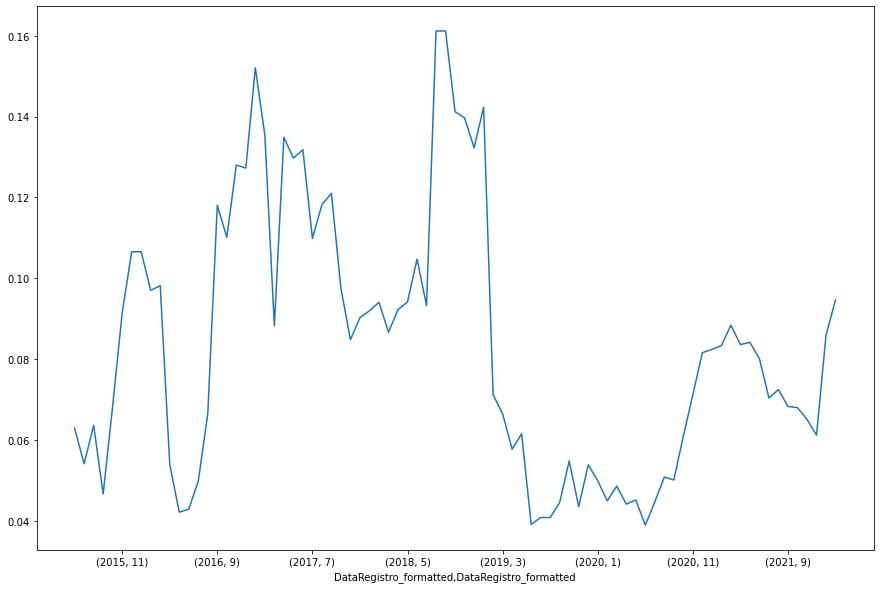

In [100]:
pedidos_access_to_information_denied['Pedido incompreensível'].plot()

<AxesSubplot:xlabel='DataRegistro_formatted,DataRegistro_formatted'>

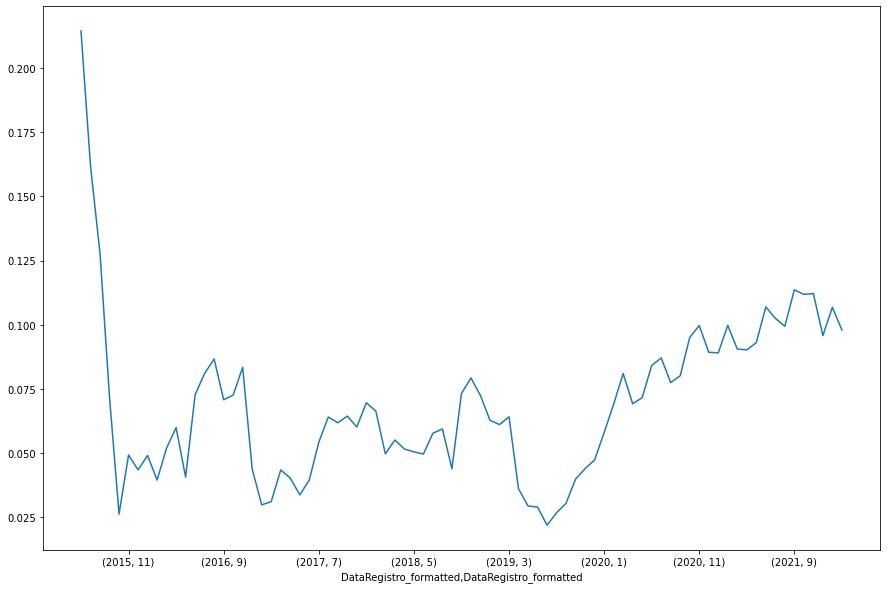

In [101]:
pedidos_access_to_information_denied['Processo decisório em curso'].plot()

# Text analysis - denials over personal data claims

Upon reading the texts we can see that, regardless of its classification, all requests are some form of "access to information", so for the time being we will ignote this classification

We will first try to understand the topics covered in the responses and requests that were denied due to "personal data" claims

## Resquests topic analysis

In [102]:
personal_data_denials = pedidos[(pedidos.Decisao == 'Acesso Negado') & \
                                (pedidos.EspecificacaoDecisao == 'Dados pessoais')]

In [103]:
requests_details = personal_data_denials.DetalhamentoSolicitacao.to_list()

In [104]:
model = BERTopic(verbose=True)

In [105]:
requests_topics, requests_probabilities = model.fit_transform(requests_details)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/208 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [248]:
model.get_topic_freq().head(11)

,Topic,Count
0,-1,2637
1,0,205
2,1,159
3,2,142
4,3,130
5,4,119
6,5,101
7,6,96
8,7,83
9,8,83


In [249]:
personal_data_denials['requests_topics'] = requests_topics
personal_data_denials['requests_probabilities'] = requests_probabilities

In [273]:
for t in set(requests_topics):
    personal_data_denials.loc[personal_data_denials.requests_topics == t,
                              'request_topics_top_words'] = str([a_tuple[0] for a_tuple in model.get_topic(t)])[1:-1]

## Responses topic analysis

In [277]:
responses_details = personal_data_denials.Resposta.to_list()
model_responses = BERTopic(verbose=True)
responses_topics, responses_probabilities = model_responses.fit_transform(responses_details)

Batches:   0%|          | 0/206 [00:00<?, ?it/s]

2021-12-16 13:10:58,873 - BERTopic - Transformed documents to Embeddings
2021-12-16 13:11:11,624 - BERTopic - Reduced dimensionality with UMAP
2021-12-16 13:11:11,963 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [278]:
personal_data_denials['responses_topics'] = responses_topics
personal_data_denials['responses_probabilities'] = responses_probabilities

In [279]:
for t in set(responses_topics):
    personal_data_denials.loc[personal_data_denials.responses_topics == t,
                              'responses_topics_top_words'] = str([a_tuple[0] for a_tuple in model_responses.get_topic(t)])[1:-1]

In [281]:
personal_data_denials.to_csv('../data/personal_data_denials.csv',index=False)

# Text analysis - denials over secrecy

In [282]:
secrecy_denials = pedidos[(pedidos.Decisao == 'Acesso Negado') & \
                ((pedidos.EspecificacaoDecisao == 'Informação sigilosa classificada conforme a Lei 12.527/2011') |\
                (pedidos.EspecificacaoDecisao == 'Informação sigilosa de acordo com legislação específica'))]

In [283]:
requests_details = secrecy_denials.DetalhamentoSolicitacao.to_list()

In [284]:
secrecy_denial_model = BERTopic(verbose=True)
requests_topics, requests_probabilities = secrecy_denial_model.fit_transform(requests_details)

Batches:   0%|          | 0/279 [00:00<?, ?it/s]

2021-12-16 13:31:11,792 - BERTopic - Transformed documents to Embeddings
2021-12-16 13:31:21,865 - BERTopic - Reduced dimensionality with UMAP
2021-12-16 13:31:22,285 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [285]:
secrecy_denials['requests_topics'] = requests_topics
secrecy_denials['requests_probabilities'] = requests_probabilities

In [286]:
for t in set(requests_topics):
    secrecy_denials.loc[secrecy_denials.requests_topics == t,
                              'requests_topics_top_words'] = \
    str([a_tuple[0] for a_tuple in secrecy_denial_model.get_topic(t)])[1:-1]

In [296]:
responses_details = secrecy_denials.Resposta.to_list()
secrecy_denial_model = BERTopic(verbose=True)
responses_topics, responses_probabilities = secrecy_denial_model.fit_transform(responses_details)

Batches:   0%|          | 0/279 [00:00<?, ?it/s]

2021-12-16 13:48:58,620 - BERTopic - Transformed documents to Embeddings
2021-12-16 13:49:11,050 - BERTopic - Reduced dimensionality with UMAP
2021-12-16 13:49:11,564 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [297]:
secrecy_denials['responses_topics'] = responses_topics
secrecy_denials['responses_probabilities'] = responses_probabilities

In [298]:
for t in set(responses_topics):
    secrecy_denials.loc[secrecy_denials.responses_topics == t,
                              'responses_topics_top_words'] = \
    str([a_tuple[0] for a_tuple in secrecy_denial_model.get_topic(t)])[1:-1]

In [299]:
secrecy_denials.to_csv('../data/secrecy_denials.csv',index=False)

In [303]:
secrecy_denial_model.get_topic_freq()

,Topic,Count
0,-1,1883
1,0,281
2,1,155
3,2,109
4,3,101
...,...,...
247,246,10
248,247,10
249,248,10
250,249,10


# Classification based on departments

Given that the topics are being separated mostly by the department they were included we will try to create different topic models for each one of them (at least the ones that have high volume of requests)

In [28]:
pedidos_count = pedidos.shape[0]

In [22]:
top_departments = pedidos[['OrgaoDestinatario',
         'IdPedido']].groupby('OrgaoDestinatario').count().sort_values(by='IdPedido',ascending=False)

In [30]:
top_departments['proportion'] = top_departments/pedidos_count

In [33]:
top_departments['proportion_cumsum'] = top_departments.proportion.cumsum()

In [44]:
top_departments[top_departments.proportion_cumsum <= 0.9]

,IdPedido,proportion,proportion_cumsum
OrgaoDestinatario,,,
ME - Ministério da Economia,56757,0.091920,0.091920
MCIDADANIA - Ministério da Cidadania (Desenvolvimento Social e Esporte),30646,0.049632,0.141552
MS – Ministério da Saúde,28302,0.045836,0.187388
ANEEL – Agência Nacional de Energia Elétrica,22954,0.037175,0.224563
ANVISA – Agência Nacional de Vigilância Sanitária,18317,0.029665,0.254228
...,...,...,...
UNILAB – Universidade da Integração Internacional da Lusofonia Afro-Brasileira,950,0.001539,0.893649
ITI – Instituto Nacional de Tecnologia da Informação,946,0.001532,0.895181
"IFAM – Instituto Federal de Educação, Ciência e Tecnologia do Amazonas",942,0.001526,0.896706


In [62]:
top_dep_denied_access = pedidos[pedidos.Decisao == 'Acesso Negado'][['OrgaoDestinatario',
         'IdPedido']].groupby(['OrgaoDestinatario']).count().sort_values(by='IdPedido',ascending=False)

In [63]:
pedidos_denied_count = pedidos[pedidos.Decisao == 'Acesso Negado'].shape[0]

In [64]:
pedidos_denied_count

40455

In [65]:
top_dep_denied_access['proportion'] = top_dep_denied_access/pedidos_denied_count

In [66]:
top_dep_denied_access

,IdPedido,proportion
OrgaoDestinatario,,
ME - Ministério da Economia,5820,0.143864
CEF – Caixa Econômica Federal,2633,0.065085
PETROBRAS – Petróleo Brasileiro S.A.,2098,0.051860
INSS – Instituto Nacional do Seguro Social,2017,0.049858
MS – Ministério da Saúde,1485,0.036707
...,...,...
INSA – Instituto Nacional do Semi-Árido,1,0.000025
FUNPRESP - Fundação de Previdência Complementar do Servidor Público Federal do Poder Executivo,1,0.000025
EBSERH - CHC-UFC (MEAC) - Maternidade Escola Assis Chateaubriand,1,0.000025


In [68]:
top_departments_combined = top_departments.join(top_dep_denied_access,lsuffix='', rsuffix='_denied')

In [70]:
top_departments_combined.fillna(0,inplace=True)

In [73]:
top_departments_combined['share_denied'] = top_departments_combined['IdPedido_denied']/top_departments_combined['IdPedido']

In [78]:
#Highest share of denials
top_departments_combined[top_departments_combined.IdPedido >= 1000].sort_values(by='share_denied',
                                                                                ascending=False).head(10)

,IdPedido,proportion,proportion_cumsum,IdPedido_denied,proportion_denied,share_denied
OrgaoDestinatario,,,,,,
GSI-PR – Gabinete de Segurança Institucional da Presidência da República,1221,0.001977,0.842902,367.0,0.009072,0.300573
TRANSPETRO - Petrobras Transporte S.A,1994,0.003229,0.729773,535.0,0.013225,0.268305
CEF – Caixa Econômica Federal,11898,0.019269,0.382691,2633.0,0.065085,0.221298
FINEP – Financiadora de Estudos e Projetos,1115,0.001806,0.865269,242.0,0.005982,0.217040
ANTAQ – Agência Nacional de Transportes Aquaviários,3582,0.005801,0.635176,703.0,0.017377,0.196259
BB – Banco do Brasil S.A.,4153,0.006726,0.604912,812.0,0.020072,0.195521
MRE – Ministério das Relações Exteriores,5886,0.009533,0.551138,1027.0,0.025386,0.174482
DATAPREV – Empresa de Tecnologia e Informações da Previdência,1810,0.002931,0.751214,292.0,0.007218,0.161326
AGU – Advocacia-Geral da União,4576,0.007411,0.583757,708.0,0.017501,0.154720


# Analysis GSI

In [93]:
pedidos_gsi = pedidos[pedidos.OrgaoDestinatario == \
                      'GSI-PR – Gabinete de Segurança Institucional da Presidência da República']

In [94]:
top_gsi_assuntos = pedidos_gsi[['AssuntoPedido','IdPedido']].groupby('AssuntoPedido').count().sort_values('IdPedido',ascending=False)

In [95]:
top_gsi_assuntos['proportion'] = top_gsi_assuntos/pedidos_gsi.shape[0]

In [97]:
top_gsi_assuntos.head()

,IdPedido,proportion
AssuntoPedido,,
Outros em Defesa Nacional,516,0.422604
Acesso à informação,221,0.180999
Serviços Públicos,186,0.152334
Outros em Segurança e Ordem Pública,83,0.067977
Transparência,30,0.024570


In [102]:
pedidos_gsi_denied = pedidos_gsi[pedidos_gsi.Decisao == 'Acesso Negado'][['AssuntoPedido',
                                                     'IdPedido']].groupby('AssuntoPedido').count().sort_values('IdPedido',
                                                                                                               ascending=False)

In [107]:
pedidos_gsi_denied['proportion'] = pedidos_gsi_denied.IdPedido/pedidos_gsi[pedidos_gsi.Decisao == 'Acesso Negado'].shape[0]

In [110]:
pedidos_gsi_denied.head()

,IdPedido,proportion
AssuntoPedido,,
Outros em Defesa Nacional,222,0.604905
Acesso à informação,68,0.185286
Transparência,18,0.049046
Serviços Públicos,18,0.049046
Outros em Segurança e Ordem Pública,7,0.019074


In [113]:
top_gsi_combined = top_gsi_assuntos.join(pedidos_gsi_denied,lsuffix='', rsuffix='_denied')

In [115]:
top_gsi_combined['share_denied'] = top_gsi_combined.IdPedido_denied/top_gsi_combined.IdPedido

In [118]:
top_gsi_combined[top_gsi_combined.IdPedido > 10].sort_values(by='share_denied',ascending=False)

,IdPedido,proportion,IdPedido_denied,proportion_denied,share_denied
AssuntoPedido,,,,,
Transparência,30,0.024570,18.0,0.049046,0.600000
Outros em Defesa Nacional,516,0.422604,222.0,0.604905,0.430233
Acesso à informação,221,0.180999,68.0,0.185286,0.307692
Outros em Economia e Finanças,13,0.010647,4.0,0.010899,0.307692
Coronavírus (COVID-19),17,0.013923,5.0,0.013624,0.294118
Serviços Públicos,186,0.152334,18.0,0.049046,0.096774
Outros em Segurança e Ordem Pública,83,0.067977,7.0,0.019074,0.084337
Direitos Humanos,13,0.010647,1.0,0.002725,0.076923
Telecomunicações,17,0.013923,1.0,0.002725,0.058824


## Text analysis on GSI

In [247]:
gsi_responses_model = BERTopic(verbose=True,language='Portuguese',nr_topics="auto")

In [248]:
pedidos_gsi_requests_list = pedidos_gsi.DetalhamentoSolicitacao.to_list()

In [249]:
topics, probabilities = gsi_responses_model.fit_transform(pedidos_gsi_requests_list)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

2021-12-17 16:38:58,342 - BERTopic - Transformed documents to Embeddings
2021-12-17 16:39:03,639 - BERTopic - Reduced dimensionality with UMAP
2021-12-17 16:39:03,706 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-17 16:39:05,846 - BERTopic - Reduced number of topics from 31 to 19


In [250]:
gsi_responses_model.get_topic_freq()

,Topic,Count
0,-1,372
1,0,124
2,1,99
3,2,96
4,3,87
5,4,84
6,5,75
7,6,62
8,7,56
9,8,37


In [251]:
pedidos_gsi['requests_topics'] = topics

In [258]:
for t in set(topics):
    pedidos_gsi.loc[pedidos_gsi.requests_topics == t,
                              'requests_topics_top_words'] = \
    str([a_tuple[0] for a_tuple in gsi_responses_model.get_topic(t)])[1:-1]

In [265]:
top_topics_pedidos_gsi = pedidos_gsi[['IdPedido','requests_topics_top_words']].groupby('requests_topics_top_words').count()

In [266]:
top_topics_pedidos_gsi_denied = pedidos_gsi[pedidos_gsi.Decisao == "Acesso Negado" ][['IdPedido',
                                                              'requests_topics_top_words']].groupby('requests_topics_top_words').count()

In [267]:
top_topics_pedidos_gsi_combined =  top_topics_pedidos_gsi.join(top_topics_pedidos_gsi_denied,
                                                               lsuffix='', rsuffix='_denied')

In [268]:
top_topics_pedidos_gsi_combined['share_denied'] = top_topics_pedidos_gsi_combined['IdPedido_denied']/\
top_topics_pedidos_gsi_combined['IdPedido']

In [269]:
top_topics_pedidos_gsi_combined.fillna(0,inplace=True)

In [364]:
top_topics_pedidos_gsi_combined.sort_values(by='share_denied',ascending=False)

,IdPedido,IdPedido_denied,share_denied
requests_topics_top_words,,,
"'desclassificado', 'receber', 'cópia', 'base', 'documento', 'já', 'gostaria', '2012', '00091', 'informação'",62,58.0,0.935484
"'05', '2017', '31', '2018', '12', '00185', '01', '04', 'desclassificadas', '11'",12,10.0,0.833333
"'lei', '527', '12', 'parágrafo', '2011', 'artigo', '11', 'de', 'informações', 'da'",87,47.0,0.540230
"'entrada', 'de', 'palácio', 'da', 'do', 'planalto', 'saída', 'registros', 'que', '2019'",124,50.0,0.403226
"'00091', '2012', '2014', 'documentos', 'que', '2015', '05', 'desclassificados', '2013', 'documento'",75,29.0,0.386667
"'coronavírus', 'março', 'pandemia', 'covid', 'de', 'órgão', 'quais', 'assédio', '2020', 'início'",12,4.0,0.333333
"'espacial', 'de', 'desenvolvimento', 'alcântara', 'do', 'quilombolas', 'questão', 'da', 'programa', 'pesquisa'",14,4.0,0.285714
"'de', 'da', 'do', 'que', 'em', 'ou', 'no', 'por', 'se', 'acesso'",372,87.0,0.233871
"'de', 'órgão', 'servidores', 'que', 'ou', 'da', 'em', 'para', '01', 'informação'",84,19.0,0.226190


In [259]:
pedidos_gsi.to_csv('../data/pedidos_gsi.csv',index=False)

In [368]:
# gsi_responses_model.save("gsi_requests_model")

In [296]:
temp1 = pedidos_gsi[['IdPedido',
             'DataRegistro_formatted',
             'Decisao']].groupby(['DataRegistro_formatted',
                                 'Decisao']).count()
temp2 = temp1.reset_index(level=1)
temp3 = temp2.pivot(columns='Decisao',values='IdPedido').fillna(0)
temp4 = temp3.groupby([temp3.index.year]).sum()

Text(0.5, 1.0, 'Pedidos ao GSI')

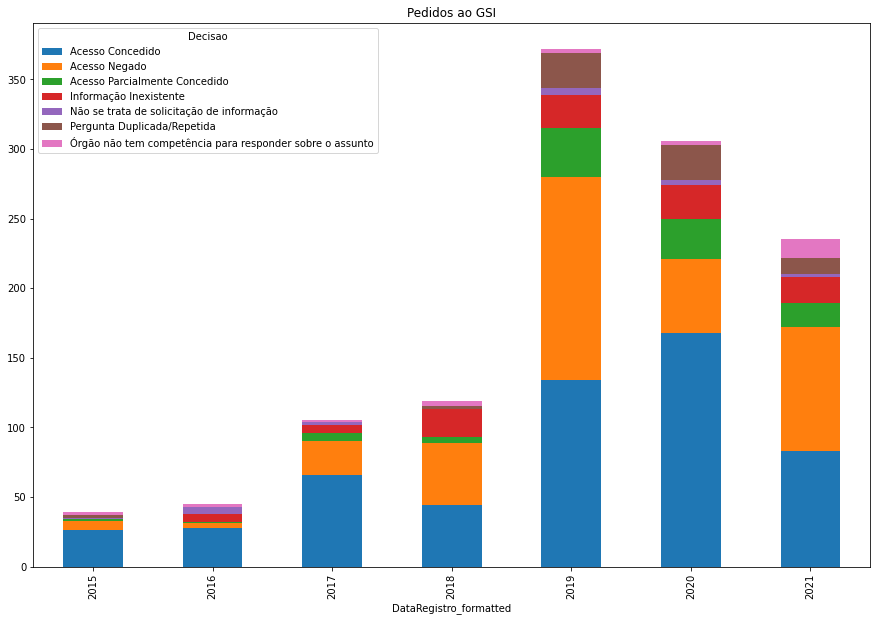

In [299]:
temp4.plot.bar(stacked=True)
plt.title('Pedidos ao GSI')

Text(0.5, 1.0, 'Pedidos ao GSI')

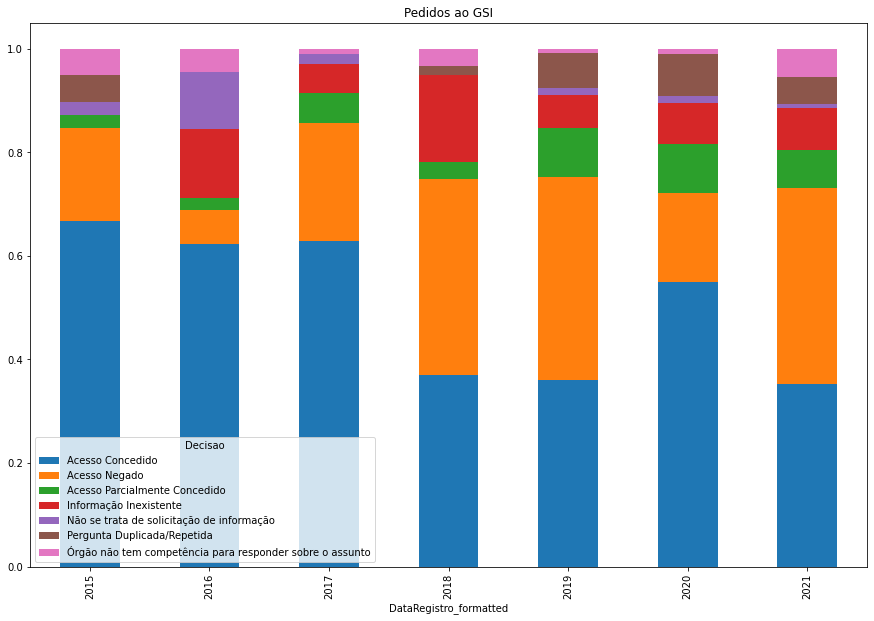

In [300]:
temp4.div(temp4.sum(axis=1).values,axis=0).plot.bar(stacked=True)
plt.title('Pedidos ao GSI')

# Analysis on TRANSPETRO

In [304]:
pedidos_trptr = pedidos[pedidos.OrgaoDestinatario == 'TRANSPETRO - Petrobras Transporte S.A']

In [310]:
pedidos_trptr.groupby('AssuntoPedido').count().sort_values(by='IdPedido',ascending=False).head()

,IdPedido,ProtocoloPedido,Esfera,OrgaoDestinatario,Situacao,DataRegistro,ResumoSolicitacao,DetalhamentoSolicitacao,PrazoAtendimento,FoiProrrogado,FoiReencaminhado,FormaResposta,OrigemSolicitacao,IdSolicitante,SubAssuntoPedido,Tag,DataResposta,Resposta,Decisao,EspecificacaoDecisao,DataRegistro_formatted,PrazoAtendimento_formatted,DataResposta_formatted
AssuntoPedido,,,,,,,,,,,,,,,,,,,,,,,
Outros em Energia,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702
Acesso à informação,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166
Licitações,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
Produção Industrial,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
Preservação e Conservação Ambiental,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


Most requests done are aggregated in one topic, that doesnt tell much about the nature of the different topics that can be found within

In [313]:
pedidos_trptr_list = pedidos_trptr.DetalhamentoSolicitacao.to_list()

In [314]:
trptr_responses_model = BERTopic(verbose=True,language='Portuguese',nr_topics="auto")
topics, probabilities = trptr_responses_model.fit_transform(pedidos_trptr_list)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2021-12-17 17:34:57,764 - BERTopic - Transformed documents to Embeddings
2021-12-17 17:35:04,764 - BERTopic - Reduced dimensionality with UMAP
2021-12-17 17:35:04,856 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-17 17:35:08,035 - BERTopic - Reduced number of topics from 50 to 32


In [317]:
trptr_responses_model.get_topic_freq()

,Topic,Count
0,0,418
1,-1,347
2,1,170
3,2,164
4,3,131
5,4,95
6,5,61
7,6,47
8,7,47
9,8,41


In [322]:
pedidos_trptr['requests_topics'] = topics
pedidos_trptr['requests_probabilities'] = probabilities

In [325]:
for t in set(topics):
    pedidos_trptr.loc[pedidos_trptr.requests_topics == t,
                              'requests_topics_top_words'] = \
    str([a_tuple[0] for a_tuple in trptr_responses_model.get_topic(t)])[1:-1]

In [345]:
pedidos_trptr['request_topics_complete'] = pedidos_trptr['requests_topics'].astype(str)+\
':'+pedidos_trptr['requests_topics_top_words']

In [369]:
pedidos_trptr.to_csv('../data/pedidos_trptr.csv',index=False)

In [367]:
# trptr_responses_model.save("trptr_requests_model")

In [359]:
temp1 = pedidos_trptr[['IdPedido','request_topics_complete']].groupby('request_topics_complete').count()
temp1['proportion'] = temp1/temp1.sum()

temp2 = pedidos_trptr[pedidos_trptr.Decisao == 'Acesso Negado'][['IdPedido','request_topics_complete']].groupby('request_topics_complete').count()
temp2['proportion'] = temp2/temp2.sum()
temp3 = temp1.join(temp2,lsuffix='', rsuffix='_denied').fillna(0).sort_values('proportion_denied',ascending=False)

In [374]:
temp3.head()

,IdPedido,proportion,IdPedido_denied,proportion_denied
request_topics_complete,,,,
"0:'seus', 'envio', 'nº', 'cópia', 'anexos', 'firmado', 'solicito', 'ltda', 'com', 'contrato'",418,0.209629,291.0,0.543925
"-1:'de', 'da', 'que', 'em', 'do', 'transpetro', 'para', 'por', 'solicito', 'no'",347,0.174022,63.0,0.117757
"8:'brasil', 'envio', 'seus', 'nº', 'firmado', 'cópia', 'anexos', 'solicito', 'com', 'do'",41,0.020562,39.0,0.072897
"1:'serviços', 'contrato', 'dos', 'os', 'empresa', 'de', 'transpetro', 'que', 'da', 'do'",170,0.085256,33.0,0.061682
"3:'serem', 'fornecidas', 'parágrafo', 'informações', 'artigo', '2011', '527', 'detalhada', 'bem', 'descrição'",131,0.065697,27.0,0.050467
